In [55]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

import lightgbm as lgb
from tensorflow import keras
from keras.models import Sequential,Model
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from keras.optimizers import Adam
from keras.initializers import RandomNormal
import keras.backend as K
from sklearn.utils import shuffle

np.random.seed(1635848)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import DatasetFolder
from torchvision.utils import save_image
from tqdm import tqdm
import pandas as pd


In [88]:
df = pd.read_csv('transactions_202308041617 (1).csv')
# def _df(df):
#     df = pd.DataFrame(df)
#     for c in range(df.shape[1]):
#         mapping = {df.columns[c]: c}
#         df = df.rename(columns=mapping)
#     return df

# X = (df.drop(columns=["category","transaction_id","user_id"])).values
# y = (df["category"]).values



# X = KNNImputer().fit_transform(X)
# data = _df(StandardScaler().fit_transform(np.column_stack((X, y))))
# data
df = df.drop(columns="merchant_id")
df


,id,transaction_id,user_id,date,description,amount,type,account_id,currency,institution_id,category,cleaned_description
0,143526,01H63E6F75C15GXQ9W0F7HSG49,test_user_id,20230630,BAT STARBUCKS@CITY SI NG 25MAY 4628-1234-5678-...,40.00,2,test_account_id,NGN,test_institution_id,51,"Bat Starbucks City SI -1234-5678-1234, NG, 25..."
1,143527,01H63E6F4NTS0Y5ZJ5K8VHVKB4,test_user_id,20220716,BEST MART 101: Jul_16,200.00,2,test_account_id,HKD,test_institution_id,51,Best Mart 101 Jul 16
2,143528,01H63E6F4KJWMH8SZ432VFNCRC,test_user_id,20220715,TRANSFER WITHDRAWAL: Jul_15,99.00,2,test_account_id,HKD,test_institution_id,51,Transfer Withdrawal Jul 15
3,143529,01H63E6F4HFHJ68SMDDPE367Q7,test_user_id,20220714,LOAN REPAYMENT: Jul_14,686.00,2,test_account_id,HKD,test_institution_id,51,Loan Repayment Jul 14
4,143530,01H63E6F4EKTVR5RT0SCNKR9CH,test_user_id,20220713,FINANCE CHARGE: Jul_13,582.00,2,test_account_id,HKD,test_institution_id,51,Finance Charge Jul 13
...,...,...,...,...,...,...,...,...,...,...,...,...
1300,145357,202104301001001000000030000000101,1001001,20210430,CUSTODIAN FEE SEC\n081732232380,25.00,2,1001001hsbc-hk00000003,HKD,00000003,0,Custodian Fee Sec
1301,145358,202104081001001000000030000000301,1001001,20210408,SEC\nP142666001 PURCHASE,1582.11,2,1001001hsbc-hk00000003,HKD,00000003,1,Sec Purchase
1302,145359,202104081001001000000030000000201,1001001,20210408,SEC\nP142666001 PUR CHARGES,30.00,2,1001001hsbc-hk00000003,HKD,00000003,1,Sec Pur Charges
1303,145360,202104011001001000000030000000101,1001001,20210401,MR LAU PAK CHING\nHC12140131059847 01APR,2000.00,1,1001001hsbc-hk00000003,MRO,00000003,0,"MR Lau Pak Ching, 01 April, 2023"


In [95]:
class cGAN():
    
    """
    Class containing 3 methods (and __init__): generator, discriminator and train.
    Generator is trained using random noise and label as inputs. Discriminator is trained
    using real/fake samples and labels as inputs.
    """
    
    def __init__(self,latent_dim=32, out_shape=11):
        
        self.latent_dim = latent_dim
        self.out_shape = out_shape 
        self.num_classes = 2
        # using Adam as our optimizer
        optimizer = Adam(0.0002, 0.5)
        
        # building the discriminator
        self.discriminator = self.discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # building the generator
        self.generator = self.generator()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])
        
        # we don't train discriminator when training generator
        self.discriminator.trainable = False
        valid = self.discriminator([gen_samples, label])

        # combining both models
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer,
                             metrics=['accuracy'])


    def generator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        
        model_input = multiply([noise, label_embedding])
        gen_sample = model(model_input)

        return Model([noise, label], gen_sample, name="Generator")

    
    def discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(512, input_dim=self.out_shape, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(256, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Dense(128, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Dense(1, activation='sigmoid'))
        
        gen_sample = Input(shape=(self.out_shape,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))

        model_input = multiply([gen_sample, label_embedding])
        validity = model(model_input)

        return Model(inputs=[gen_sample, label], outputs=validity, name="Discriminator")


    def train(self, X_train, y_train, pos_index, neg_index, epochs, sampling=False, batch_size=32, sample_interval=100, plot=True): 
        
        # though not recommended, defining losses as global helps as in analysing our cgan out of the class
        global G_losses
        global D_losses
        
        G_losses = []
        D_losses = []
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            
            # if sampling==True --> train discriminator with 8 sample from positive class and rest with negative class
            if sampling:
                idx1 = np.random.choice(pos_index, 8)
                idx0 = np.random.choice(neg_index, batch_size-8)
                idx = np.concatenate((idx1, idx0))
            # if sampling!=True --> train discriminator using random instances in batches of 32
            else:
                idx = np.random.choice(len(y_train), batch_size)
            samples, labels = X_train[idx], y_train[idx]
            print(samples,labels)
            samples, labels = shuffle(samples, labels)
            
            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_samples = self.generator.predict([noise, labels])

            # label smoothing
            if epoch < epochs//1.5:
                valid_smooth = (valid+0.1)-(np.random.random(valid.shape)*0.1)
                fake_smooth = (fake-0.1)+(np.random.random(fake.shape)*0.1)
            else:
                valid_smooth = valid 
                fake_smooth = fake
                
            # Train the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)
            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            if (epoch+1)%sample_interval==0:
                print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, d_loss[0], g_loss[0]))
            G_losses.append(g_loss[0])
            D_losses.append(d_loss[0])
            if plot:
                if epoch+1==epochs:
                    plt.figure(figsize=(10,5))
                    plt.title("Generator and Discriminator Loss")
                    plt.plot(G_losses,label="G")
                    plt.plot(D_losses,label="D")
                    plt.xlabel("iterations")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.show()

In [96]:
le = preprocessing.LabelEncoder()
for i in ['transaction_id','user_id','description','amount','account_id','currency','institution_id','category','cleaned_description']:
    df[i] = le.fit_transform(df[i].astype(str))



In [97]:
scaler = StandardScaler()

X = scaler.fit_transform(df.drop('category', 1))
y = df['category'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

/var/folders/kt/qhh82_bx7rvfrpqcmr4hbg_80000gn/T/ipykernel_5261/3145713062.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = scaler.fit_transform(df.drop('category', 1))


In [98]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train, y_train)

y_pred = lgb_1.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
# plot_confusion_matrix(lgb_1, X_test, y_test)
# plt.show()

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 1044, number of used features: 11
[LightGBM] [Info] Start training from score -0.984668
[LightGBM] [Info] Start training from score -2.376104
[LightGBM] [Info] Start training from score -6.950815
[LightGBM] [Info] Start training from score -2.188641
[LightGBM] [Info] Start training from score -3.339897
[LightGBM] [Info] Start training from score -5.852202
[LightGBM] [Info] Start training from score -5.852202
[LightGBM] [Info] Start training from score -1.013279
[LightGBM] [Info] Start training from score -4.311757
[LightGBM] [Info] Start training from score -5.852202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/mubeen/Library/Python/3.9/lib/python/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2023-08-25 16:07:02.337716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[[ 2.55169571e-01  7.96345433e-01 -3.16760585e-01 -2.74451223e-02
   1.06730022e+00  1.22247279e+00  5.00000000e-01 -5.90039722e-01
  -4.11319409e+00 -3.60069796e-01  9.83400223e-01]
 [ 9.62910385e-01 -2.20322236e-01 -3.16760585e-01 -1.31524660e+00
  -6.96499436e-01 -1.54431681e+00  5.00000000e-01 -5.90039722e-01
   2.95911218e-01 -3.60069796e-01 -8.91858964e-01]
 [-4.69523118e-01 -1.61392674e+00 -3.16760585e-01  1.23798270e+00
   1.37588396e+00 -3.68755974e-01  5.00000000e-01  1.14811341e+00
   1.03076210e+00 -3.60069796e-01  1.28721316e+00]
 [ 9.71386323e-01 -2.30940175e-01 -3.16760585e-01 -1.31590465e+00
  -1.16424741e+00  5.34022792e-01  5.00000000e-01 -5.90039722e-01
   2.95911218e-01 -3.60069796e-01 -1.57980321e+00]
 [ 8.06105534e-01  5.30896955e-03 -3.16760585e-01 -1.30627172e-01
  -6.96499436e-01 -1.54431681e+00  5.00000000e-01 -5.90039722e-01
   2.95911218e-01 -3.60069796e-01 -8.91858964e-01]
 [-3.50859987e-01  1.66170747e+00 -3.16760585e-01  1.20784406e+00
   1.22971271e+00 -

2023-08-25 16:07:02.796560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-25 16:07:03.669073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[[ 1.23792534e-01  9.82159367e-01 -3.16760585e-01 -1.37577075e-02
  -2.02765462e-01 -7.90918706e-01 -2.00000000e+00 -5.90039722e-01
   2.95911218e-01 -3.60069796e-01 -4.83282940e-01]
 [ 6.21753885e-01  2.70757447e-01 -3.16760585e-01 -9.27235621e-02
   3.10458011e-01 -1.05720597e+00  5.00000000e-01 -5.90039722e-01
   2.95911218e-01 -3.60069796e-01  5.43395274e-01]
 [-3.89001708e-01  1.71745165e+00 -3.16760585e-01  1.20994982e+00
   3.36444010e-01  7.02887885e-01  5.00000000e-01 -5.90039722e-01
   2.95911218e-01 -3.60069796e-01  5.71332096e-01]
 [ 1.02602689e-01  1.01135870e+00 -3.16760585e-01 -1.29680490e-02
   4.20898506e-01 -8.62361630e-01  5.00000000e-01 -5.90039722e-01
   2.95911218e-01 -3.60069796e-01  6.79587282e-01]
 [ 2.76359416e-01  7.67146100e-01 -3.16760585e-01 -2.87612199e-02
  -1.36888715e+00  1.34587420e+00  5.00000000e-01 -5.90039722e-01
   2.95911218e-01 -3.60069796e-01  3.93234855e-01]
 [-8.44583369e-01 -1.08568427e+00 -3.16760585e-01  1.25114367e+00
  -7.51719683e-01 -

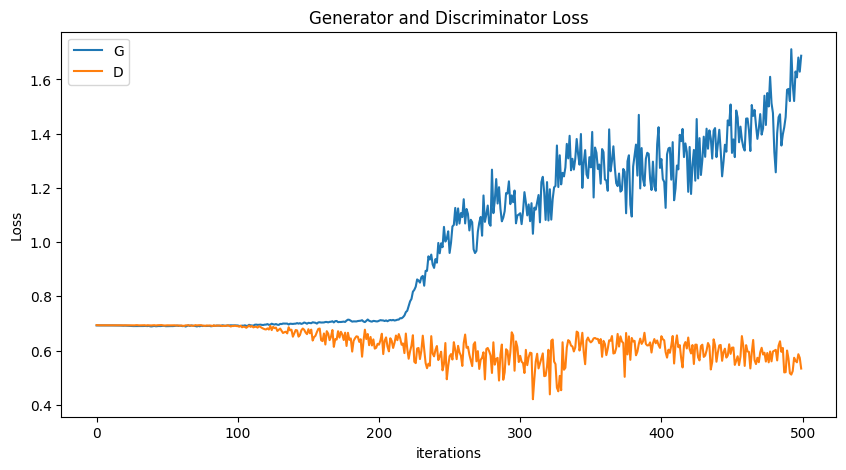

In [99]:
cgan = cGAN()
y_train = y_train.reshape(-1,1)
pos_index = np.where(y_train==1)[0]
neg_index = np.where(y_train==0)[0]
cgan.train(X_train, y_train, pos_index, neg_index, epochs=500)

In [111]:
# we want to generate 19758 instances with class value 0 since that represents how many 0s are in the label of the real training set
noise = np.random.normal(0, 1, (19758, 32))
sampled_labels = np.zeros(19758).reshape(-1, 1)


gen_samples = cgan.generator.predict([noise, sampled_labels])

gen_df = pd.DataFrame(data = gen_samples,
                      columns = df.drop('category',1).columns)

gen_df

618/618 [==============================] - 1s 2ms/step


/var/folders/kt/qhh82_bx7rvfrpqcmr4hbg_80000gn/T/ipykernel_5261/940566453.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  columns = df.drop('category',1).columns)


,id,transaction_id,user_id,date,description,amount,type,account_id,currency,institution_id,cleaned_description
0,0.998545,0.885189,-0.567492,-0.980791,0.938386,-0.763196,0.957007,-0.999993,-0.851916,-0.688142,-0.576987
1,0.768048,0.466065,-0.477449,-0.877031,0.964231,-0.978644,0.996716,0.074475,0.985390,-0.712241,-0.981528
2,0.828942,0.726427,-0.294954,0.391555,0.083542,0.935167,0.056034,-0.622122,0.999909,-0.872732,0.611327
3,0.955591,0.967769,-0.331970,0.699377,0.788467,-0.558431,1.000000,0.641638,0.993833,-0.720658,-0.300910
4,0.996455,0.966627,-0.164114,-0.999832,0.943805,-0.997944,-0.939169,-1.000000,-0.999993,0.365725,-0.690149
...,...,...,...,...,...,...,...,...,...,...,...
19753,0.625833,0.966362,-0.663301,0.114237,0.940470,-0.607995,0.861892,-0.999976,0.079571,-0.753689,0.855448
19754,0.974727,-0.340800,-0.605630,-0.691736,0.735913,0.247058,0.993605,0.786047,0.999966,-0.718256,-0.760792
19755,0.995096,0.986162,-0.513376,0.113616,0.682708,0.863423,0.999965,-0.903920,0.998909,-0.685904,-0.273855
19756,0.900232,0.645810,-0.668946,-0.864425,0.903774,-0.697569,0.999773,0.858242,0.991407,-0.841961,-0.707857


In [112]:
# we want to generate 6290 instances with class value 1 since that represents how many 1s are in the label of the real training set
noise_2 = np.random.normal(0, 1, (6290, 32))
sampled_labels_2 = np.ones(6290).reshape(-1, 1)


gen_samples_2 = cgan.generator.predict([noise_2, sampled_labels_2])

gen_df_2 = pd.DataFrame(data = gen_samples_2,
                      columns = df.drop('category',1).columns)

gen_df_2

197/197 [==============================] - 0s 2ms/step


/var/folders/kt/qhh82_bx7rvfrpqcmr4hbg_80000gn/T/ipykernel_5261/2215877646.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  columns = df.drop('category',1).columns)


,id,transaction_id,user_id,date,description,amount,type,account_id,currency,institution_id,cleaned_description
0,0.999320,-0.993418,0.468819,-0.452174,0.906918,-0.738501,-0.999910,-0.434158,-0.790646,0.917044,-0.877693
1,-0.586268,0.975165,0.724807,0.794464,0.796885,-0.409269,0.955176,0.756251,0.627556,-0.095982,0.438247
2,-0.991592,-0.924843,0.125600,-0.393404,0.997638,0.520312,0.999881,-0.696447,-0.916943,-0.984123,0.997434
3,-0.979045,-0.504713,0.661312,0.979611,0.953677,-0.709359,0.327695,0.802356,0.400156,0.663699,0.695002
4,-0.999886,-0.953168,-0.357604,0.999927,0.974964,-0.980607,0.999994,-0.781013,-0.998688,-0.498391,0.999959
...,...,...,...,...,...,...,...,...,...,...,...
6285,-0.595742,0.988573,-0.108610,0.249058,0.693152,0.735426,0.999758,0.316153,0.997820,-0.609840,-0.638331
6286,0.672011,-0.694431,-0.284912,0.946002,0.968006,-0.993886,-0.894943,0.228578,0.832762,0.362084,-0.932431
6287,0.886975,-0.985288,0.489088,0.991544,-0.983630,0.999635,-1.000000,0.999024,-0.305838,0.996144,-0.989021
6288,-0.619340,0.017923,-0.308808,-0.455972,0.885604,-0.693945,0.998622,0.628937,0.899236,-0.599741,0.253615


In [113]:
gen_df_2['category'] = 1
gen_df['category']=0

df_gan = pd.concat([gen_df_2, gen_df], ignore_index=True, sort=False)
df_gan = df_gan.sample(frac=1).reset_index(drop=True)

X_train_2 = df_gan.drop('category', 1)
y_train_2 = df_gan['category'].values

df_gan


/var/folders/kt/qhh82_bx7rvfrpqcmr4hbg_80000gn/T/ipykernel_5261/2072301312.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train_2 = df_gan.drop('category', 1)


,id,transaction_id,user_id,date,description,amount,type,account_id,currency,institution_id,cleaned_description,category
0,0.310697,0.617221,-0.164011,0.035000,0.871704,-0.984365,0.999996,0.996311,0.997908,-0.336935,-0.981302,0
1,0.992661,-0.606429,-0.513992,-0.675585,0.967640,0.964631,0.997042,-0.970826,0.972569,-0.741520,0.218790,0
2,0.411903,-0.485189,-0.308093,-0.998569,0.983373,-0.998343,0.890064,-0.999867,-0.999334,-0.549426,0.050427,0
3,0.999467,0.054185,-0.395642,-0.930292,0.768621,0.032843,0.991934,-0.526229,0.913529,-0.685820,-0.992018,0
4,0.999303,-0.127787,-0.430606,-0.997568,0.920175,-0.993118,0.762467,-0.999613,-0.978359,0.682361,-0.990177,0
...,...,...,...,...,...,...,...,...,...,...,...,...
26043,0.987679,0.447648,-0.462356,-0.974596,0.862953,-0.988917,1.000000,-0.728968,0.857387,-0.626533,-0.879029,0
26044,-0.990520,-0.682534,-0.367158,-0.061306,0.973816,-0.613274,0.973133,0.954192,0.651051,0.427178,0.393356,1
26045,1.000000,0.949792,-0.100503,-0.376470,-0.458985,0.997553,-0.762292,0.413139,-0.056871,0.754768,-0.991661,1
26046,0.884897,0.573671,-0.409490,0.554868,0.732170,-0.980448,0.999999,0.940256,0.973509,0.107193,-0.996290,0


In [110]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train_2, y_train_2)


y_pred = lgb_1.predict(X_test)

print(classification_report(y_test, y_pred))
# plot_confusion_matrix(lgb_1, X_test, y_test)
# plt.show()

[LightGBM] [Info] Number of positive: 6290, number of negative: 19758
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2804
[LightGBM] [Info] Number of data points in the train set: 26048, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.241477 -> initscore=-1.144597
[LightGBM] [Info] Start training from score -1.144597
              precision    recall  f1-score   support

           0       0.42      0.29      0.34        96
           1       0.15      0.94      0.27        32
           3       0.00      0.00      0.00        36
           4       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        88

    accuracy                           0.22       261
   macro avg       0.11      0.25      0.12       261
weighted avg       0.17      0.22      0.16       261



/Users/mubeen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mubeen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mubeen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [105]:
def generate_instances(df_new, cgan,num_instances,label_class,label='category'):
    noise = np.random.normal(0, 1, (num_instances, 32))
    
    if label_class==0:
        sampled_labels = np.zeros(num_instances).reshape(-1, 1)
        gen_samples = cgan.generator.predict([noise, sampled_labels])
    else:
        sampled_labels = np.zeros(num_instances).reshape(-1, 1)
        gen_samples = cgan.generator.predict([noise, sampled_labels])
        
    gen_df = pd.DataFrame(data = gen_samples,
                          columns = df_new.drop(label,1).columns)
    return gen_df


In [85]:
def run_experiment(df_new, pos_num_inst, neg_num_inst, num_epochs, out_sh, latent_d=32, label_f='amount'):
    
    global bal_acc, acc, G_loss, D_loss
    G_loss = []
    D_loss = []
    bal_acc = []
    acc = []
    
    X = scaler.fit_transform(df_new.drop(label_f, 1))
    y = df_new[label_f].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    cgan=cGAN(latent_dim=latent_d, out_shape=out_sh)
    y_train = y_train.reshape(-1,1)
    pos_index = np.where(y_train==1)[0]
    neg_index = np.where(y_train==0)[0]
    
    for i in range(5):
        print(str(i+1)+". RUN")
        
        cgan.train(X_train, y_train, pos_index, neg_index, epochs=num_epochs, plot=False)
        gen_df = generate_instances(df_new, cgan=cgan,num_instances=pos_num_inst, label_class=1, label=label_f)
        gen_df_2 = generate_instances(df_new,cgan=cgan, num_instances=neg_num_inst, label_class=0, label=label_f)
        
        gen_df[label_f] = 1
        gen_df_2[label_f] = 0

        df_gan = pd.concat([gen_df_2, gen_df], ignore_index=True, sort=False)
        df_gan = df_gan.sample(frac=1).reset_index(drop=True)

        X_train_2 = df_gan.drop(label_f, 1)
        y_train_2 = df_gan[label_f].values
        
        lgb_1 = lgb.LGBMClassifier()
        lgb_1.fit(X_train_2, y_train_2)
        
        y_pred = lgb_1.predict(X_test)
        
        G_loss.append(G_losses)
        D_loss.append(D_losses)
        
        bal_acc.append(balanced_accuracy_score(y_test, y_pred))
        acc.append(accuracy_score(y_test, y_pred))
        
        print("Bal_Acc:", bal_acc[i])
        print("Acc:", acc[i])
       
    Sum_G_loss = [sum(x) for x in zip(*G_loss)]
    Sum_D_loss = [sum(x) for x in zip(*D_loss)]
    Avg_G_loss = [x / 5 for x in Sum_G_loss]
    Avg_D_loss = [x / 5 for x in Sum_D_loss]
    
    plt.figure(figsize=(10,5))
    plt.title("Average Generator and Discriminator Loss")
    plt.plot(Avg_G_loss,label="G")
    plt.plot(Avg_D_loss,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [86]:
%%time
run_experiment(df_new=df, pos_num_inst=6290, neg_num_inst=19758, num_epochs=2000, out_sh=14)

/var/folders/kt/qhh82_bx7rvfrpqcmr4hbg_80000gn/T/ipykernel_5261/3145300810.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = scaler.fit_transform(df_new.drop(label_f, 1))
/Users/mubeen/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/mubeen/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/mubeen/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:1076: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/mubeen/Library/Python/3.9/lib/python/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseede

1. RUN
[[-6.26780993e-02  1.24495336e+00 -3.16760585e-01             nan
   5.87756067e-04  4.24146755e-01  5.00000000e-01 -5.90039722e-01
   2.95911218e-01 -3.60069796e-01 -7.32965689e-02  6.86571488e-01]
 [ 1.39942119e+00 -9.58269004e-01 -3.16760585e-01             nan
  -1.37104914e+00  1.05105897e+00 -2.00000000e+00 -5.90039722e-01
  -4.11319409e+00 -3.60069796e-01 -1.02981679e+00  9.62447606e-01]
 [-3.50859987e-01  1.66170747e+00 -3.16760585e-01             nan
   1.20784406e+00  1.22971271e+00 -2.00000000e+00 -5.90039722e-01
   2.95911218e-01 -3.60069796e-01 -7.10976718e-01  1.33261050e+00]
 [ 1.32101876e+00 -7.27328829e-01 -3.16760585e-01             nan
  -1.35841460e+00 -1.50856189e+00  5.00000000e-01 -5.90039722e-01
   2.95911218e-01 -3.60069796e-01  1.20206373e+00 -1.11884564e+00]
 [ 6.53538652e-01  2.22976721e-01 -3.16760585e-01             nan
  -9.49609279e-02  8.88646481e-01 -2.00000000e+00 -5.90039722e-01
   2.95911218e-01 -3.60069796e-01 -1.02981679e+00  1.07070279e+00

2023-08-25 16:03:24.929848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


ValueError: in user code:

    File "/Users/mubeen/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/mubeen/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/mubeen/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/mubeen/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/Users/mubeen/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/mubeen/Library/Python/3.9/lib/python/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "Discriminator" is incompatible with the layer: expected shape=(None, 14), found shape=(32, 12)


In [40]:
import os 
import logging
import tensorflow as tf

tf.get_logger().setLevel(logging.ERROR)

def _noise(data):
    noise = np.random.normal(0, 1, data.shape)
    return noise

def _generator(data):
    model = tf.keras.Sequential(name="Generator_model")
    model.add(tf.keras.layers.Dense(15, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=data.shape[1]))
    model.add(tf.keras.layers.Dense(30, activation='relu'))
    model.add(tf.keras.layers.Dense(
            data.shape[1], activation='linear'))
    return model


def _discriminator(data):
        model = tf.keras.Sequential(name="Discriminator_model")
        model.add(tf.keras.layers.Dense(25, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=data.shape[1]))
        model.add(tf.keras.layers.Dense(50, activation='relu'))
        # sigmoid => real or fake
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

In [41]:
def _GAN(generator, discriminator):
        discriminator.trainable = False
        generator.trainable = True
        model = tf.keras.Sequential(name="GAN")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model

In [44]:
def train(data,generator, discriminator, gan):

        # determine half the size of one batch, for updating the  discriminator
        # manually enumerate epochs
        for epoch in range(500):
            
            # Train the discriminator
            generated_data = generator.predict(_noise(df))
            labels = np.concatenate([np.ones(data.shape[0]), np.zeros(data.shape[0])])
            X = np.concatenate([data, generated_data])
            discriminator.trainable = True

            X_tensor = tf.convert_to_tensor(X)
            labels_tensor = tf.convert_to_tensor(labels)

            d_loss , _ = discriminator.train_on_batch(X_tensor, labels_tensor)




            # Train the generator
            noise = _noise()
            g_loss = gan.train_on_batch(noise, np.ones(data.shape[0]))


            print('>%d, d1=%.3f, d2=%.3f' %(epoch+1, d_loss, g_loss))

        return generator

In [45]:

generator = _generator(df)
descriminator = _discriminator(df)
gan_model = _GAN(generator=generator, discriminator=descriminator)
trained_model = train(df,
    generator=generator, discriminator=descriminator, gan=gan_model)

41/41 [==============================] - 0s 2ms/step


2023-08-25 13:10:21.088178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

Sequential(
  (0): Linear(in_features=1000, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=13, bias=True)
  (5): Sigmoid()
)

Sequential(
  (0): Linear(in_features=13, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): LeakyReLU(negative_slope=0.2, inplace=True)
  (4): Linear(in_features=128, out_features=1, bias=True)
  (5): Sigmoid()
)